## AutoARIMA

- Univariate
- The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, setting on a single fitted ARIMA model. Accept only univariate dataset.
- AR(auto regression model) MA(moving average model) -> ARMA
- ARIMA: Auto Regressive Integrated Moving Average

In [1]:
from darts import TimeSeries
from darts.models import StatsForecastAutoARIMA
from darts.utils.statistics import plot_hist
from darts.metrics import mape
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [3]:
df = df.drop(['date', 'day_of_week', 'time', 'month'], axis=1)

In [4]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(
    df, 
    time_col="datetime", 
    value_cols='energy_price',
    freq='H'
)

splitting_point = (int(len(series)*0.20))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

In [5]:
model = StatsForecastAutoARIMA()

In [6]:
model.fit(train)

forecast = model.predict(len(val))
print(f'model {model} obtains MAPE: {mape(val, forecast):.2f}%')

model Auto-ARIMA-Statsforecasts obtains MAPE: 1792.64%


## Historical forecasts
Forecasting using historical data.

*Backtesting: General method for seeing how well a model would have done using historical data.

In [7]:
historical_fcast = model.historical_forecasts(
    series,
    start=0.80,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

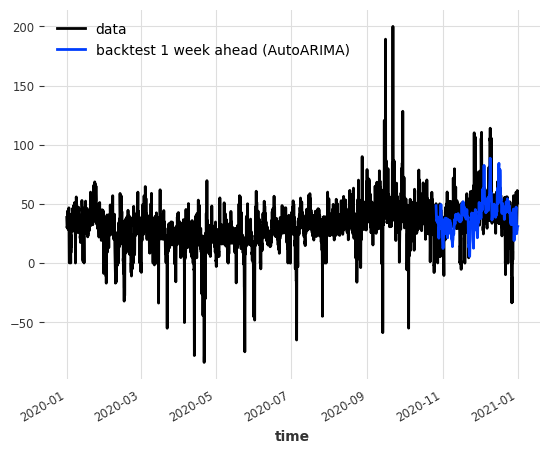

In [8]:
series.plot(label='data')
historical_fcast.plot(label='backtest 1 week ahead (AutoARIMA)')

In [9]:
print(f'MAPE = {mape(historical_fcast, series):.2f}%')

MAPE = 39.29%


## Backtest
It repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

In [10]:
raw_errors = model.backtest(
    series,
    start=0.80,
    forecast_horizon=168,
    stride=5,
    reduction=None,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

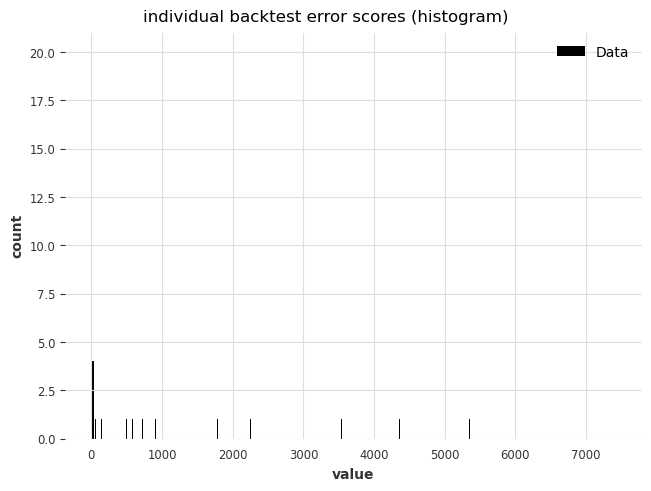

In [11]:
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title='individual backtest error scores (histogram)'
)

In [12]:
median_error = model.backtest(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    reduction=np.median,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

In [13]:
print(f'Median error (MAPE) over all historical forecasts: {median_error:.2f}%')

Median error (MAPE) over all historical forecasts: 306.96%


In [14]:
average_error = model.backtest(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    reduction=np.mean,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

In [15]:
print(f'Average error (MAPE) over all historical forecasts: {average_error:.2f}%')

Average error (MAPE) over all historical forecasts: 1471.65%
